## TabNet

In [1]:
!pip install pytorch-tabnet --quiet

In [4]:
import pandas as pd
import numpy as np

import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

from sklearn.datasets import load_boston, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
class Config:
    SEED = 42
    PATIENCE = 50
    EARLY_STOPPING_ROUNDS = PATIENCE
    VERBOSE = 50
    PRE_BATCH_SIZE = 512
    BATCH_SIZE = 128
    MAX_EPOCHS = 1_000
    N_ESTIMATORS = MAX_EPOCHS

In [28]:
X, y = load_boston(True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2, random_state=Config.SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=.9, test_size=.1, random_state=Config.SEED)

print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

363 41 102


In [30]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",
    verbose=Config.VERBOSE
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    eval_name=['valid'],
    max_epochs=Config.MAX_EPOCHS,
    patience=Config.PATIENCE,
    batch_size=Config.PRE_BATCH_SIZE,
    pretraining_ratio=0.8,
)

Device used : cuda
epoch 0  | loss: 36.95977| valid_unsup_loss: 4491.13379|  0:00:00s
epoch 50 | loss: 3.14525 | valid_unsup_loss: 7.4304  |  0:00:03s
epoch 100| loss: 2.41623 | valid_unsup_loss: 3.46587 |  0:00:06s
epoch 150| loss: 1.97719 | valid_unsup_loss: 2.75775 |  0:00:10s
epoch 200| loss: 1.73021 | valid_unsup_loss: 1.91349 |  0:00:13s
epoch 250| loss: 1.55132 | valid_unsup_loss: 1.68725 |  0:00:16s
epoch 300| loss: 1.40542 | valid_unsup_loss: 1.58318 |  0:00:19s
epoch 350| loss: 1.24125 | valid_unsup_loss: 1.56533 |  0:00:23s

Early stopping occurred at epoch 357 with best_epoch = 307 and best_valid_unsup_loss = 1.45892
Best weights from best epoch are automatically used!


In [45]:
reg_tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR, 
    scheduler_params={
        "step_size":10, 
        'gamma':.8},
    mask_type='sparsemax',
    verbose=Config.VERBOSE)

reg_tabnet.fit(
    X_train, y_train.reshape(-1, 1), 
    eval_set=[
              (X_train, y_train.reshape(-1, 1)), 
              (X_valid, y_valid.reshape(-1, 1))],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=Config.MAX_EPOCHS,
    patience=Config.PATIENCE,
    batch_size=Config.BATCH_SIZE,
    from_unsupervised=unsupervised_model
    )

Device used : cuda
Loading weights from unsupervised pretraining
epoch 0  | loss: 640.73674| train_rmse: 25.5158 | valid_rmse: 24.08679|  0:00:00s
epoch 50 | loss: 10.23642| train_rmse: 5.92872 | valid_rmse: 4.69962 |  0:00:06s
epoch 100| loss: 4.88675 | train_rmse: 3.14418 | valid_rmse: 3.43936 |  0:00:13s
epoch 150| loss: 4.07547 | train_rmse: 1.97654 | valid_rmse: 3.29723 |  0:00:20s

Early stopping occurred at epoch 183 with best_epoch = 133 and best_valid_rmse = 3.23218
Best weights from best epoch are automatically used!


In [46]:
valid_score = mean_squared_error(
    y_true=y_valid, 
    y_pred=reg_tabnet.predict(X_valid),
    squared=False
    )

test_score = mean_squared_error(
    y_true=y_test, 
    y_pred=reg_tabnet.predict(X_test),
    squared=False
    )

print(f"BEST VALID SCORE : {valid_score}")
print(f"FINAL TEST SCORE : {test_score}")

BEST VALID SCORE : 3.23218201370981
FINAL TEST SCORE : 4.079101780317554


In [47]:
reg_tabnet.feature_importances_

array([0.1669876 , 0.0320236 , 0.04103978, 0.        , 0.02943488,
       0.08357638, 0.01512086, 0.06466822, 0.07388496, 0.12451841,
       0.1370481 , 0.14169124, 0.09000599])

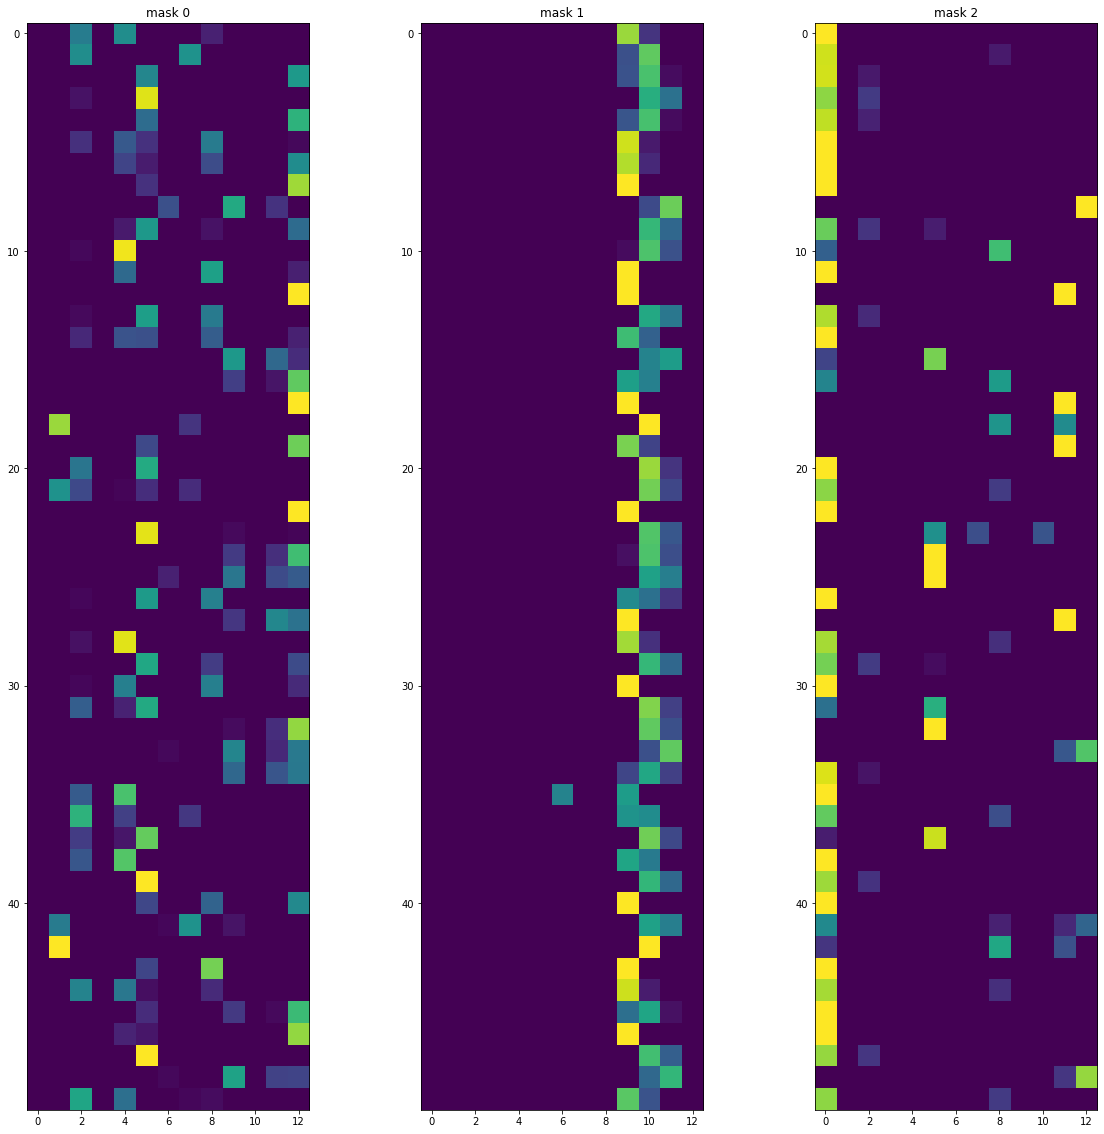

In [48]:
explain_matrix, masks = reg_tabnet.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## Benchmark: XGBoost

In [49]:
from xgboost import XGBRegressor

reg_xgb = XGBRegressor(max_depth=8,
    learning_rate=2e-2,
    n_estimators=Config.N_ESTIMATORS,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

reg_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=Config.EARLY_STOPPING_ROUNDS,
        verbose=Config.VERBOSE)

[0]	validation_0-rmse:22.7048
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:8.53614
[100]	validation_0-rmse:4.04956
[150]	validation_0-rmse:2.95627
[200]	validation_0-rmse:2.82125
Stopping. Best iteration:
[198]	validation_0-rmse:2.81742



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=0)

In [56]:
valid_score = mean_squared_error(
    y_true=y_valid, 
    y_pred=reg_xgb.predict(X_valid),
    squared=False
    )

test_score = mean_squared_error(
    y_true=y_test, 
    y_pred=reg_xgb.predict(X_test),
    squared=False
    )

print(f"BEST VALID SCORE : {valid_score}")
print(f"FINAL TEST SCORE : {test_score}")

BEST VALID SCORE : 2.8174157801888344
FINAL TEST SCORE : 3.0655554586530736


In [65]:
y_valid_pred = (reg_tabnet.predict(X_valid)[:, 0] + reg_xgb.predict(X_valid)) / 2
y_test_pred = (reg_tabnet.predict(X_test)[:, 0] + reg_xgb.predict(X_test)) / 2

valid_score = mean_squared_error(
    y_true=y_valid, 
    y_pred=y_valid_pred,
    squared=False
    )

test_score = mean_squared_error(
    y_true=y_test, 
    y_pred=y_test_pred,
    squared=False
    )

print(f"BEST VALID SCORE : {valid_score}")
print(f"FINAL TEST SCORE : {test_score}")

BEST VALID SCORE : 2.7757152195837294
FINAL TEST SCORE : 3.411661338287435
